In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re

In [ ]:
# small dataset
df = pd.read_csv("data/games.csv")
df = df[["black_rating","white_rating","moves","winner"]]
df.to_pickle("data/games.pkl")

In [5]:
df = pd.read_pickle("data/games.pkl")
print(df.head())
max_rating = max(df["black_rating"].max(), df["white_rating"].max())
df["black_rating_scaled"] = df["black_rating"] / max_rating
df["white_rating_scaled"] = df["white_rating"] / max_rating
df["winner_encoded"] = df["winner"].map({"draw": 0, "white": 1, "black": 2})
df["moves_tokenized"] = df["moves"].apply(lambda x: x.split())
unique_moves = sorted(list(set(m for row in df["moves_tokenized"] for m in row)))
move_to_idx = {move: i for i, move in enumerate(unique_moves)}
df["moves_encoded"] = df["moves_tokenized"].apply(lambda row: [move_to_idx[m] for m in row])
df.drop(columns=["black_rating", "white_rating", "moves", "winner","moves_tokenized"], inplace=True)
print(df.head())
print("unique_moves", len(unique_moves))
df.to_pickle("data/games_prepared.pkl")

   black_rating  white_rating  \
0          1191          1500   
1          1261          1322   
2          1500          1496   
3          1454          1439   
4          1469          1523   

                                               moves winner  
0  d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...  white  
1  d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...  black  
2  e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...  white  
3  d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...  white  
4  e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...  white  
   black_rating_scaled  white_rating_scaled  winner_encoded  \
0             0.437385             0.550863               1   
1             0.463092             0.485494               2   
2             0.550863             0.549394               1   
3             0.533970             0.528461               1   
4             0.539479             0.559310               1   

                                       moves_encod

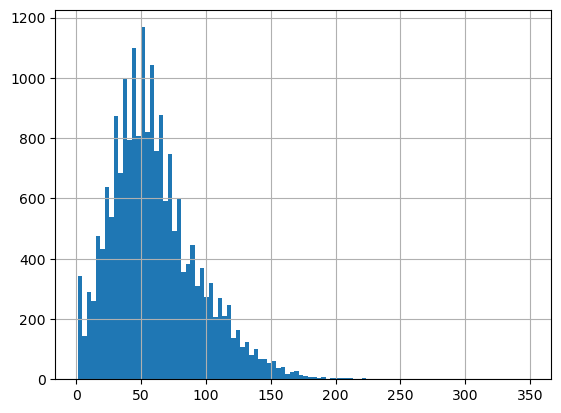

In [ ]:
df = pd.read_pickle("data/games_prepared.pkl")
df["moves_encoded_length"] = df["moves_encoded"].apply(len)
df["moves_encoded_length"].hist(bins=100)
plt.show()

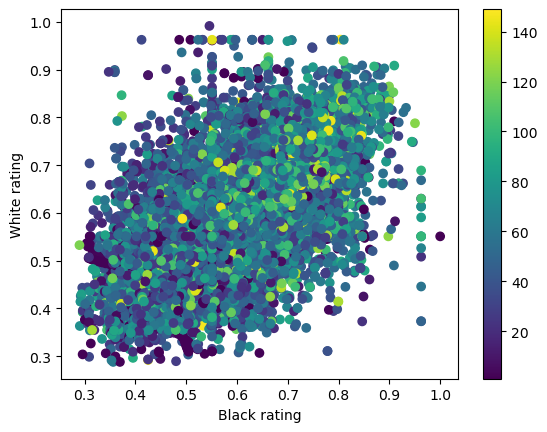

In [ ]:
df = pd.read_pickle("data/games_prepared.pkl")
df = df[df["moves_encoded"].apply(len) < 150]
plt.scatter(df["black_rating_scaled"], df["white_rating_scaled"], c=df["moves_encoded"].apply(len))
plt.xlabel("Black rating")
plt.ylabel("White rating")
plt.colorbar()
plt.show()

In [ ]:
# split up 6.25 million games into 5 sets of 1.25 million games each (4Gb -> ~700Mb)
input_file = r"C:\Projekte\chess_elo_prediction\data\chess_games.csv"
output_dir = "data/split_data"
os.makedirs(output_dir, exist_ok=True)
cols = ["WhiteElo", "BlackElo", "AN"]
chunksize = 100000
target = 1250000
current_file = 1
current_count = 0

for chunk in pd.read_csv(input_file, usecols=cols, chunksize=chunksize):
    start_idx = 0
    while start_idx < len(chunk) and current_file <= 5:
        remaining = target - current_count
        subset = chunk.iloc[start_idx:start_idx + remaining]
        out_path = os.path.join(output_dir, f"set_{current_file}.csv")
        subset.to_csv(out_path, mode='a', header=(current_count == 0), index=False)
        n_written = len(subset)
        current_count += n_written
        start_idx += n_written
        if current_count >= target:
            current_file += 1
            current_count = 0
            if current_file > 5:
                break

In [12]:
# idea: only keep games that ended in a draw and use a bot that will always try to draw for the demonstration (trained on this exact dataset)

df_full = pd.DataFrame(columns=["WhiteElo", "BlackElo", "AN"])
unique_moves = set()
max_rating = 0

def is_valid_row(token_list):
    for token in token_list:
        if token in {"{", "}"} or "[%eval" in token:
            return False
    return True

for i in range(1, 6):
    input_file = fr"C:\Projekte\chess_elo_prediction\data\split_data\set_{i}.csv"
    df_tmp = pd.read_csv(input_file, usecols=["WhiteElo", "BlackElo", "AN"])
    max_rating_tmp = max(df_tmp["WhiteElo"].max(), df_tmp["BlackElo"].max())

    # we accept that we wont capture all tokens (by this exec order) -> on set_1 ~8K unique_moves, on the 220K draws -> 7384 unique moves TODO!!!
    df_tmp["Result"] = df_tmp["AN"].apply(lambda x: "Draw" if "1/2-1/2" in x else "NA")
    df_tmp = df_tmp[df_tmp["Result"] == "Draw"]

    df_tmp["AN"] = df_tmp["AN"].apply(lambda x: re.sub(r"\d+\.", "", x))
    df_tmp["AN"] = df_tmp["AN"].str.replace("1/2-1/2", "", regex=False)
    df_tmp["moves_tokenized"] = df_tmp["AN"].apply(lambda x: x.split())
    df_tmp = df_tmp[df_tmp["moves_tokenized"].apply(is_valid_row)]
    
    df_tmp["moves_tokenized"] = df_tmp["moves_tokenized"].apply(lambda x: ["<EOS>"] + x + ["<EOS>"])

    for token_list in df_tmp["moves_tokenized"]:
        unique_moves.update(token_list)
    
    df_full = pd.concat([df_full, df_tmp], ignore_index=True)
    max_rating = max(max_rating, max_rating_tmp)

unique_moves = sorted(unique_moves)
move_to_idx = {move: i + 1 for i, move in enumerate(unique_moves)}
df_full["black_rating_scaled"] = df_full["BlackElo"] / max_rating
df_full["white_rating_scaled"] = df_full["WhiteElo"] / max_rating
df_full["moves_encoded"] = df_full["moves_tokenized"].apply(lambda row: [move_to_idx[move] for move in row])

print("before balance", len(df_full))
print(df_full["Result"].value_counts())

# balance dataset
df_full["avg_rating_scaled"] = (df_full["black_rating_scaled"] + df_full["white_rating_scaled"]) / 2

df_full["rating_bin_10"] = pd.cut(df_full["avg_rating_scaled"], bins=10, labels=False) # ten bins -> ~7K games overall
groups = df_full.groupby("rating_bin_10")
min_count_ten = groups.size().min()
print("min_count_ten", min_count_ten)

df_full["rating_bin_5"] = pd.cut(df_full["avg_rating_scaled"], bins=5, labels=False) # five bins -> ~8K games overall
groups = df_full.groupby("rating_bin_5")
min_count_five = groups.size().min()
print("min_count_five", min_count_five)

df_full["rating_bin"] = pd.cut(df_full["avg_rating_scaled"], bins=3, labels=False) # three bins -> ~48K games overall -> best compromise, prior tests showed we need about 20-40k games for training
groups = df_full.groupby("rating_bin")
min_count = groups.size().min()
print("min_count", min_count)

df_bal_subset = groups.apply(lambda x: x.sample(min_count, random_state=13)).reset_index(drop=True)
df_bal_subset = df_bal_subset.sample(frac=1, random_state=13).reset_index(drop=True)

# save all games that not have been used for training as test set (220k - 48k = ~172k)
df_test = df_full[~df_full.index.isin(df_bal_subset.index)]
df_test.reset_index(drop=True, inplace=True)
df_test.drop(columns=["WhiteElo", "BlackElo", "AN", "moves_tokenized", "avg_rating_scaled", "Result", "rating_bin", "rating_bin_10", "rating_bin_5"], inplace=True)
print("test set info", df_test.info())
df_test.to_csv(r"C:\Projekte\chess_elo_prediction\data\final_test_set.csv", index=False)

df_bal_subset.drop(columns=["WhiteElo", "BlackElo", "AN", "moves_tokenized", "avg_rating_scaled", "Result", "rating_bin", "rating_bin_10", "rating_bin_5"], inplace=True)

moves_df = pd.DataFrame({"move": unique_moves, "token_number": range(1, len(unique_moves) + 1)})
moves_df.to_csv(r"C:\Projekte\chess_elo_prediction\data\unique_moves.csv", index=False)

print(df_bal_subset.info())
print(df_bal_subset.head())
print(len(df_bal_subset))

print("unique_moves", len(unique_moves))
print("max_rating", max_rating)

output_file = r"C:\Projekte\chess_elo_prediction\data\final_normalized.csv"
df_bal_subset.to_csv(output_file, index=False)

before balance 220191
Result
Draw    220191
Name: count, dtype: int64
min_count_ten 76
min_count_five 1614
min_count 16072


C:\Users\maxmo\AppData\Local\Temp\ipykernel_11936\3005715906.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_bal_subset = groups.apply(lambda x: x.sample(min_count, random_state=13)).reset_index(drop=True)
C:\Users\maxmo\AppData\Local\Temp\ipykernel_11936\3005715906.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(columns=["WhiteElo", "BlackElo", "AN", "moves_tokenized", "avg_rating_scaled", "Result", "rating_bin", "rating_bin_10", "rating_bin_5"], inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171975 entries, 0 to 171974
Data columns (total 3 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   black_rating_scaled  171975 non-null  object
 1   white_rating_scaled  171975 non-null  object
 2   moves_encoded        171975 non-null  object
dtypes: object(3)
memory usage: 3.9+ MB
test set info None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48216 entries, 0 to 48215
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   black_rating_scaled  48216 non-null  object
 1   white_rating_scaled  48216 non-null  object
 2   moves_encoded        48216 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB
None
  black_rating_scaled white_rating_scaled  \
0            0.394855            0.401286   
1            0.429582            0.416399   
2             0.48135            0.480064   
3  